/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3893.717, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3882.334, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3875.446, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3876.975, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3879.476, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3877.919, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3877.092, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3878.569, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3875.673, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3877.611, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3878.957, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3880.477, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3877.542, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3856.296, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3880.005, Time=0.19 sec

Best mode

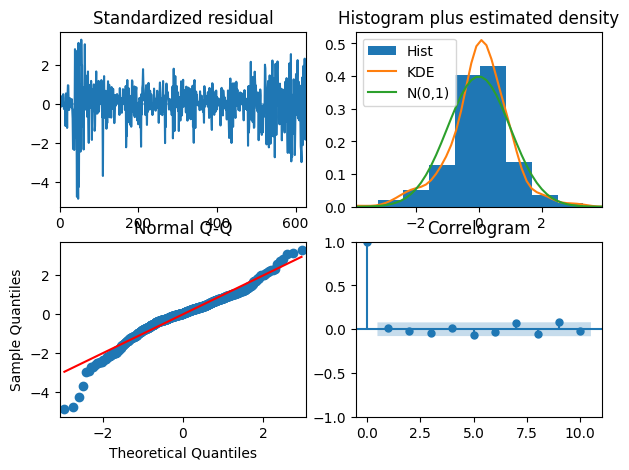

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1253706648.193008
Iteration:      2,   Func. Count:     12,   Neg. LLF: 9575378046.026888
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1968.926833650744
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3199.0520987571863
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2150.503661863399
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1885.2774124547782
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1879.701429536852
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1879.663611059556
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1879.6596784353474
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1879.6596347260843
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1879.6596347259194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1879.6596347260843
            Iterations: 11
            Function evaluations: 63
            Gradient evaluatio

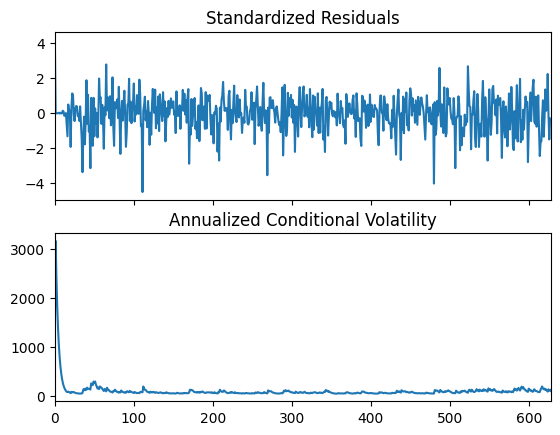

629    379.321095
630    378.971207
631    378.914858
632    379.223844
633    379.005613
          ...    
714    385.973541
715    386.057751
716    386.141961
717    386.226171
718    386.310381
Length: 90, dtype: float64


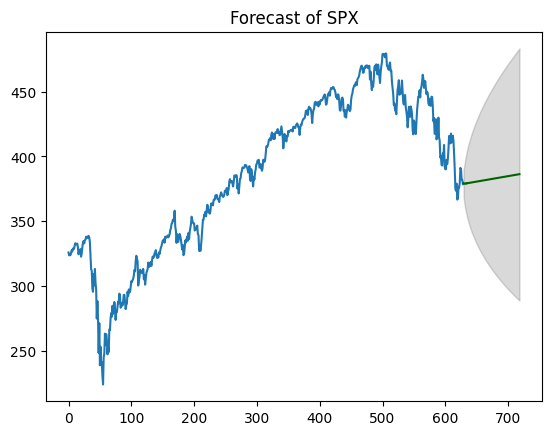

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import arch
import ivolatility as ivol
from auth import initializeIvolAuthentication

initializeIvolAuthentication()

getMarketData = ivol.setMethod('/equities/eod/stock-prices')
marketData = getMarketData(symbol='SPX', from_='2020-01-01', to='2022-06-30')

marketData['date'] = pd.to_datetime(marketData['date'])
marketData = marketData.sort_values(by='date')
marketData = marketData.reset_index(drop=True)
close_prices = marketData['close'] * 0.1  #rescaling close_prices by 0.1 to mitigate DataScaleWarning

model = pm.auto_arima(close_prices, start_p=1, start_q=1,
test='adf',
max_p=3,
max_q=3,
m=12,
start_P=0,
seasonal=False,
d=None,
D=1,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=False)

#Print ARIMA results
print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()

#Get ARIMA residuals
arima_residuals = model.arima_res_.resid

#fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

#Print GARCH results
print(garch_fitted.summary())
garch_fitted.plot(annualize='D')
plt.show()

#Forecast
n_periods = 90
index_of_fc = np.arange(len(close_prices), len(close_prices)+n_periods)

#Use ARIMA to predict mu
predicted_mu, confint = model.predict(n_periods=n_periods, return_conf_int=True)

#Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=n_periods)
predicted_et = garch_forecast.mean['h.01'].iloc[-1]
prediction = predicted_mu + predicted_et

fitted_series = pd.Series(prediction, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#Print prediction
print(prediction)

#Plot
plt.plot(close_prices)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)

plt.title('Forecast of SPX')
plt.show()